# Анализ бизнес-показателей

**Цель проекта:**

Целью данного проекта является анализ данных о пользователях, их взаимодействии с приложением, заказах и рекламных расходах компании Procrastinate Pro+ для выявления причин убытков и предложения рекомендаций по увеличению прибыли.

**Описание данных:**


Структура **visits_info_short.csv**:

- *User Id* — уникальный идентификатор пользователя,
- *Region* — страна пользователя,
- *Device* — тип устройства пользователя,
- *Channel* — идентификатор источника перехода,
- *Session Start* — дата и время начала сессии,
- *Session End* — дата и время окончания сессии.

Структура **orders_info_short.csv**:

- *User Id* — уникальный идентификатор пользователя,
- *Event Dt* — дата и время покупки,
- *Revenue* — сумма заказа.

Структура **costs_info_short.csv**:

- *dt* — дата проведения рекламной кампании,
- *Channel* — идентификатор рекламного источника,
- *costs* — расходы на эту кампанию.

## Содержание работы:

1) [Изучение данных](#1)

2) [Исследовательский анализ данных](#2)

3) [Оценка окупаемости рекламы](#3)

4) [Выводы](#4)

## Изучение данных <a id="1"></a>

In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

In [2]:
visits = pd.read_csv('visits_info_short.csv')
orders = pd.read_csv('orders_info_short.csv')
costs = pd.read_csv('costs_info_short.csv')
pd.set_option('display.max_columns', 100)

#### VISITS

In [3]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [4]:
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']

In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [6]:
visits.duplicated().sum()

0

#### ORDERS

In [7]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [8]:
orders.columns = ['user_id', 'event_dt', 'revenue']

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [10]:
orders.duplicated().sum()

0

#### HEAD

In [11]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [12]:
costs.columns = ['dt', 'channel', 'costs']

In [13]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [14]:
costs.duplicated().sum()

0

### Приведём даты к корректным форматам

In [15]:
costs.dt = pd.to_datetime(costs.dt).dt.date
visits.session_start = pd.to_datetime(visits.session_start)
visits.session_end = pd.to_datetime(visits.session_end)
orders.event_dt = pd.to_datetime(orders.event_dt)

**ВЫВОД:** в датасетах нет пропущенных данных и дубликатов. Данные приведены к корректным форматам. Изменены названия, приведены к "хорошему тону"

### Объявим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [16]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [17]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [18]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [19]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [20]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [21]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [22]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [23]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных <a id="1"></a>

### Составим профили пользователей

In [24]:
profiles = get_profiles(visits, orders, 2, costs)
display(profiles)
display(profiles.dt.min())
profiles.dt.max()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


datetime.date(2019, 5, 1)

datetime.date(2019, 10, 27)

**ВЫВОД:** минимальная дата привлечения пользователей - 01.05.2019, максимальная - 27.10.2019.

### Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей

In [25]:
country_richest = pd.pivot_table(profiles, index = 'region', values='payer', aggfunc=['count', 'mean'])
country_richest.columns = ['users_all', 'share_paying']
country_richest.sort_values('share_paying', ascending = False)

,users_all,share_paying
region,,
United States,100002,0.069019
Germany,14981,0.041119
UK,17575,0.039829
France,17450,0.037994


**ВЫВОД:** доля платящих пользователей в разрезе стран отличается значительно. Лидирует Америка (почти 7% платящих пользователей), на последнем месте Франция (3,7% платящих пользователей).

### Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи

In [26]:
device_richest = pd.pivot_table(profiles, index = 'device', values='payer', aggfunc=['count', 'mean'])
device_richest.columns = ['users_all', 'share_paying']
device_richest.sort_values('share_paying', ascending = False)

,users_all,share_paying
device,,
Mac,30042,0.063644
iPhone,54479,0.062079
Android,35032,0.058518
PC,30455,0.050468


**ВЫВОД:** доля платящих пользователей в разрезе используемого девайса отличается не так значительно как в разрезе стран. Лидирует Макинтош с 6,3% платящих пользователей, на последнем месте PC (5% платящих). Разница в процентах платящих пользователей составляет 1,3%

### Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей

In [27]:
channel_richest = pd.pivot_table(profiles, index = 'channel', values='payer', aggfunc=['count', 'mean'])
channel_richest.columns = ['users_all', 'share_paying']
channel_richest.sort_values('share_paying', ascending = False)

,users_all,share_paying
channel,,
FaceBoom,29144,0.122049
AdNonSense,3880,0.113402
lambdaMediaAds,2149,0.104700
TipTop,19561,0.096007
RocketSuperAds,4448,0.079137
WahooNetBanner,8553,0.052964
YRabbit,4312,0.038265
MediaTornado,4364,0.035747
LeapBob,8553,0.030633


**ВЫВОД:** доля платящих пользователей в разрезе источников привлечения имеет самый большой разброс. На первом месте по самомой высокой доле сконвертированных в покупку пользователей стоит FaceBoom (12%), а на последнем органические пользователи. Уже по этим данным можно сделать вывод, что скорее всего при покупке рекламы использовался таргетинг для поиска ЦА.

### Маркетинг


### Посчитаем общую сумму расходов на маркетинг

In [28]:
costs.tail()

,dt,channel,costs
1795,2019-10-23,lambdaMediaAds,4.0
1796,2019-10-24,lambdaMediaAds,6.4
1797,2019-10-25,lambdaMediaAds,8.8
1798,2019-10-26,lambdaMediaAds,8.8
1799,2019-10-27,lambdaMediaAds,12.0


In [29]:
costs['month_dt'] = pd.to_datetime(costs['dt']).dt.month
costs['week_dt'] = pd.to_datetime(costs['dt']).dt.isocalendar().week

In [30]:
costs['costs'].sum()

105497.30000000002

### Выясним, как траты распределены по рекламным источникам

In [31]:
costs_channel = pd.pivot_table(costs, index='channel', values='costs', columns = 'month_dt', aggfunc=['sum'])
costs_channel_w = pd.pivot_table(costs, index='channel', values='costs', columns = 'week_dt', aggfunc=['sum'])
costs_channel['sum_channel'] = costs_channel.sum(axis=1)
costs_channel.sort_values('sum_channel', ascending=False)

sum                                                    \
month_dt                  5         6        7         8         9         10   
channel                                                                         
TipTop              2981.00  6675.600  8410.20  11202.00  13232.50  12250.000   
FaceBoom            3524.40  5501.100  5294.30   6274.40   6114.90   5736.500   
WahooNetBanner       418.80   921.000   851.40   1040.40    977.40    942.000   
AdNonSense          1169.70   538.650   504.00    579.60    581.70    537.600   
OppleCreativeMedia   169.75   370.000   366.50    439.25    427.75    378.000   
RocketSuperAds       577.98   325.715   252.07    253.11    218.40    205.725   
LeapBob              140.28   314.580   313.53    369.81    343.98    315.420   
lambdaMediaAds       458.40   199.200   219.20    220.00    247.20    213.600   
MediaTornado         238.56   138.000   138.48    154.56    144.72    140.160   
YRabbit              299.70   106.200    97.38    124.74    152.79    163.410   

                   sum_channel  
month_dt                        
channel                         
TipTop                54751.30  
FaceBoom              32445.60  
WahooNetBanner         5151.00  
AdNonSense             3911.25  
OppleCreativeMedia     2151.25  
RocketSuperAds         1833.00  
LeapBob                1797.60  
lambdaMediaAds         1557.60  
MediaTornado            954.48  
YRabbit                 944.22

**ВЫВОД** по тратам на рекламу лидируют два источника - FaceBoom и TipTop. 

### Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику

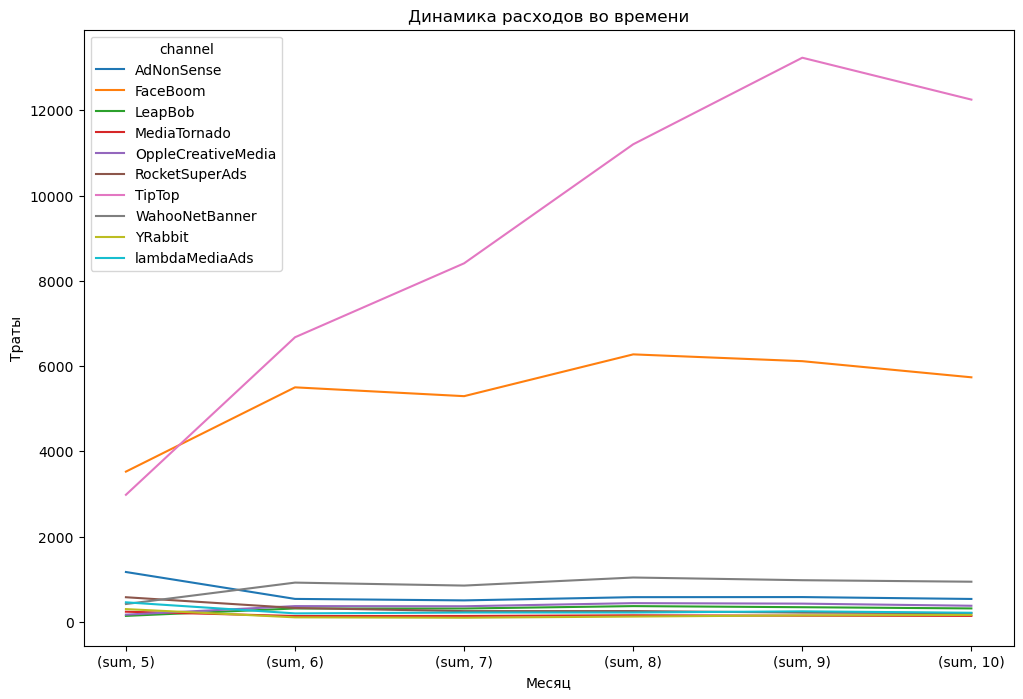

In [32]:
costs_channel = costs_channel.drop(columns='sum_channel')
costs_channel.T.plot(figsize=(12, 8))
plt.title('Динамика расходов во времени')
plt.xlabel('Месяц')
plt.ylabel('Траты');


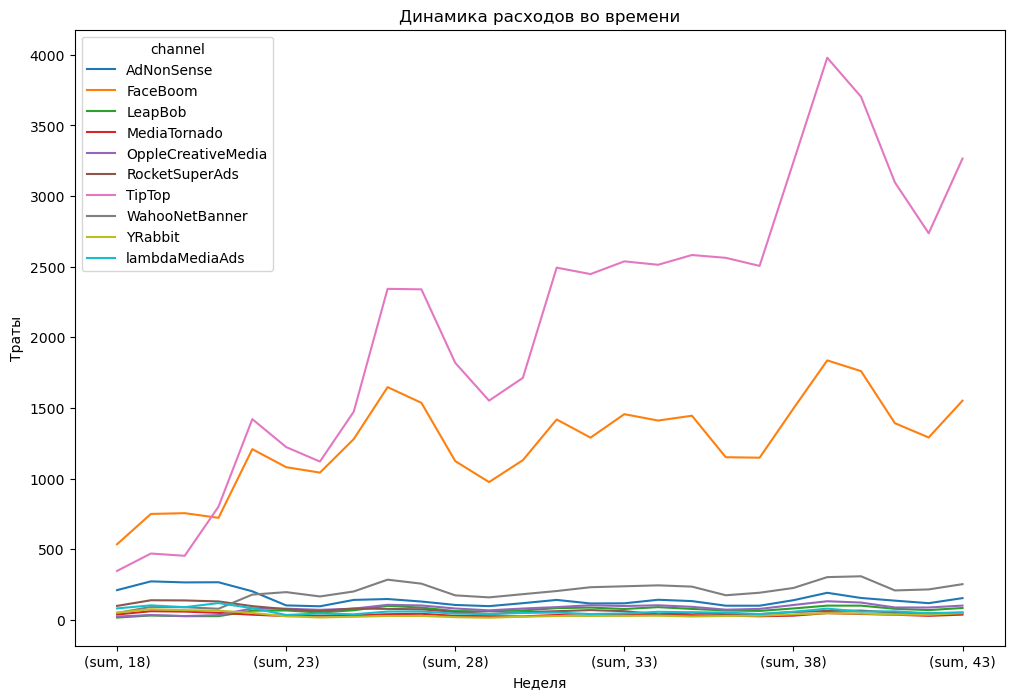

In [33]:
costs_channel_w.T.plot(figsize=(12, 8))
plt.title('Динамика расходов во времени')
plt.xlabel('Неделя')
plt.ylabel('Траты');

**ВЫВОД:** Из распределения видно, что изначально ставка была на источник FaceBoom (Самые большие траты в 1 неделю). Затем стратегия изменилась и больше всего вкладывались в источник TipTop

### Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника

In [34]:
profiles.head()
CAC = pd.pivot_table(profiles
                     , index='channel'
                     , values='acquisition_cost'
                     , aggfunc=['mean', 'sum'])
CAC.columns=['cac_mean', 'cac_sum']
CAC.sort_values('cac_mean', ascending=False)

,cac_mean,cac_sum
channel,,
TipTop,2.799003,54751.30
FaceBoom,1.113286,32445.60
AdNonSense,1.008054,3911.25
lambdaMediaAds,0.724802,1557.60
WahooNetBanner,0.602245,5151.00
RocketSuperAds,0.412095,1833.00
OppleCreativeMedia,0.250000,2151.25
YRabbit,0.218975,944.22
MediaTornado,0.218717,954.48


**ВЫВОД:** самые дорогие пользователи из самых финансируемых каналов. Самые дешёвые из LeapBob и MediaTornado

## Оценка окупаемости рекламы <a id="3"></a>

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

### Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI

Для анализа зададим момент анализа и горизонт

In [35]:
observation = datetime(2019, 11, 1).date()
horizon = 14

In [36]:
profiles = profiles.loc[profiles['channel'] != 'organic']

Рассчитаем при помощи функции get_ltv окупаемость инвестиций (**ROI**) и пожизненную ценность (**LTV**)

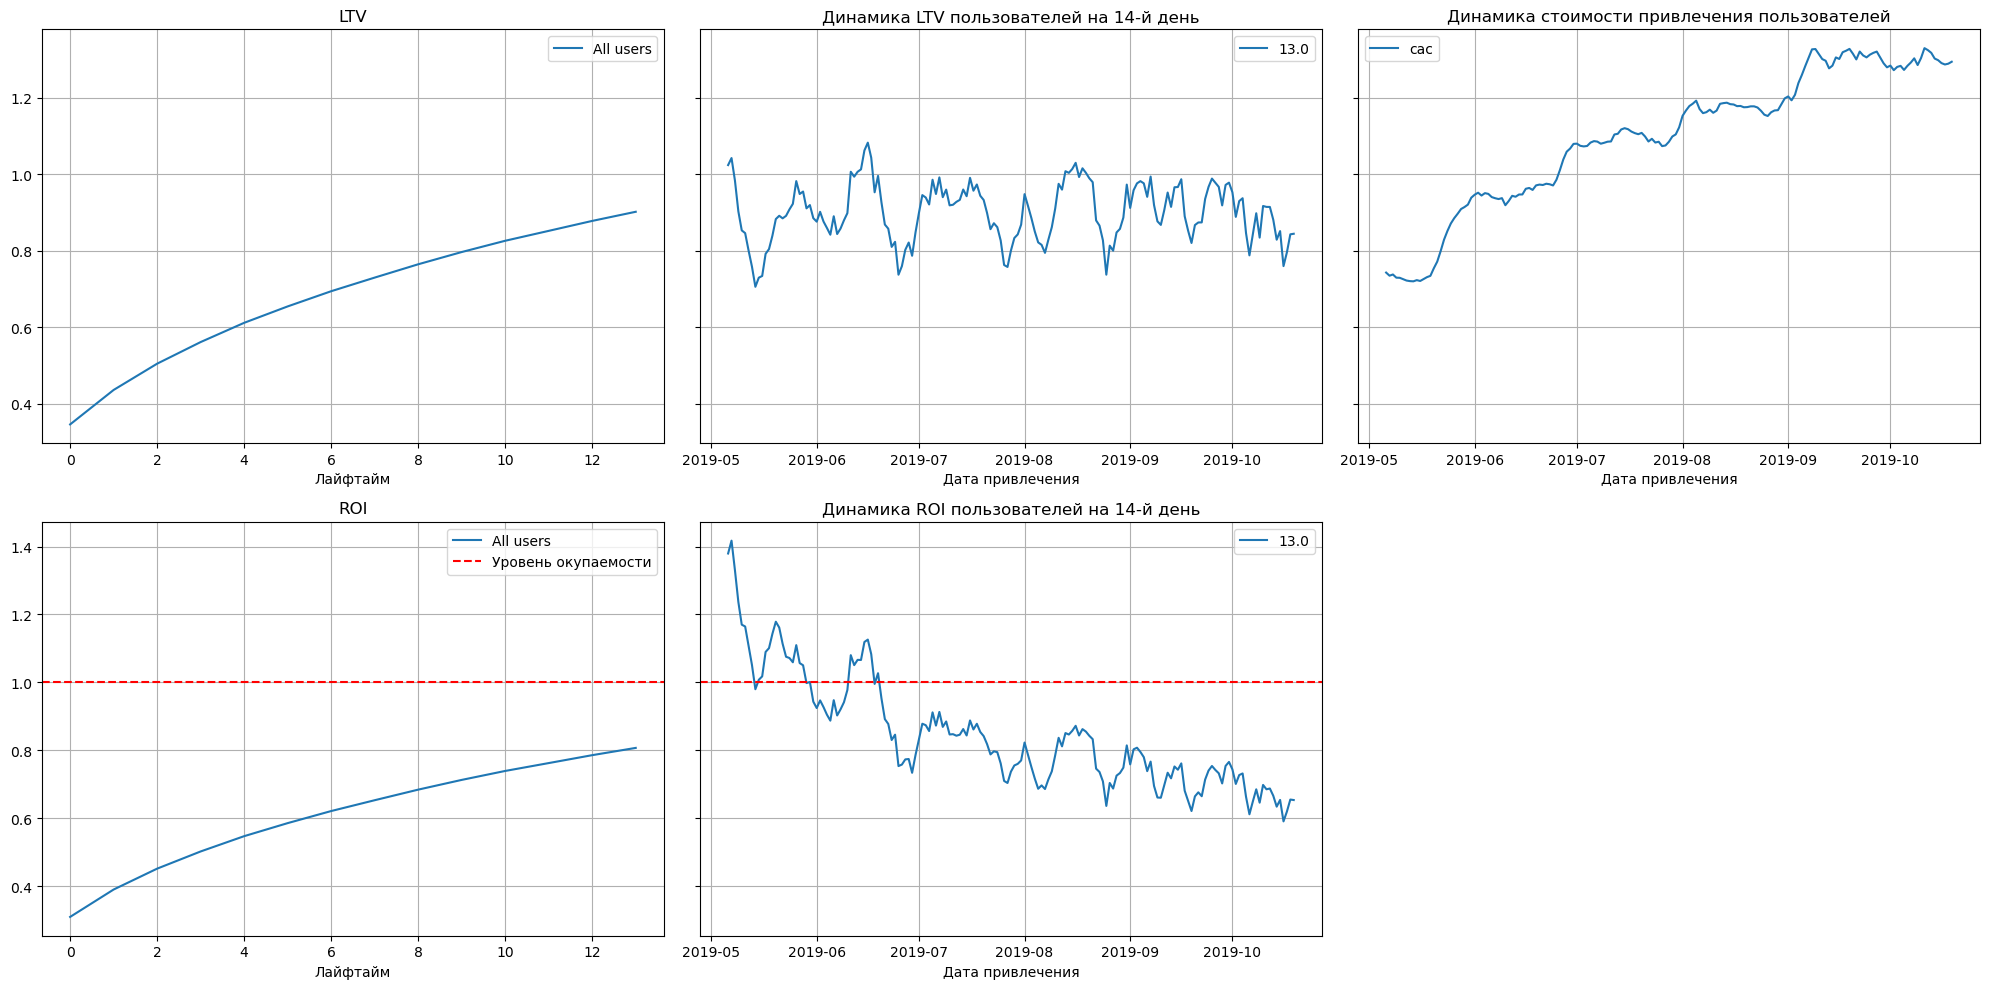

In [37]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles
                                                                      , orders
                                                                      , observation
                                                                      , horizon)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon, window = 6)

**Выводы:** 
1) Пожизненная цценность клиента растёт нормально

2) Стоимость привлечения пользователей резко выросла в июне 2019

3) Окупаемость инвестиций меньше 1, значит затраты на рекламу не окупаются

### Проверим конверсию, удержание пользователей и динамику их изменения

#### В разбивке по каналам КОНВЕРСИЯ

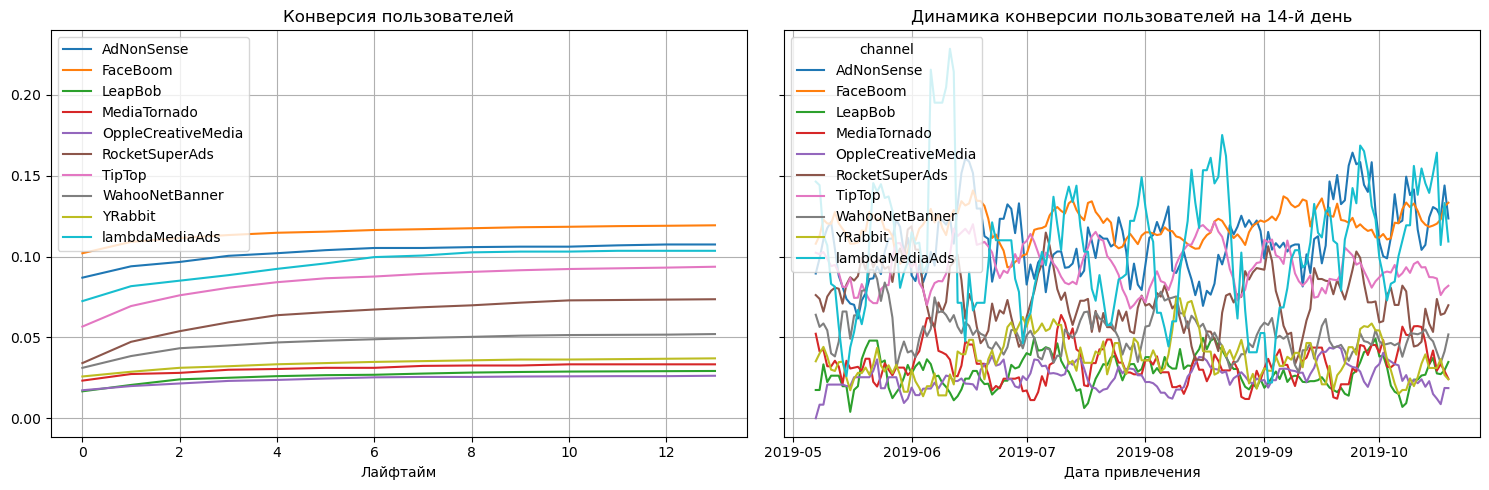

In [38]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles
                                                                        , orders
                                                                        , observation
                                                                        , horizon
                                                                        , dimensions=['channel'])
plot_conversion(conversion_grouped, conversion_history, horizon) 

#### В разбивке по каналам УДЕРЖАНИЕ

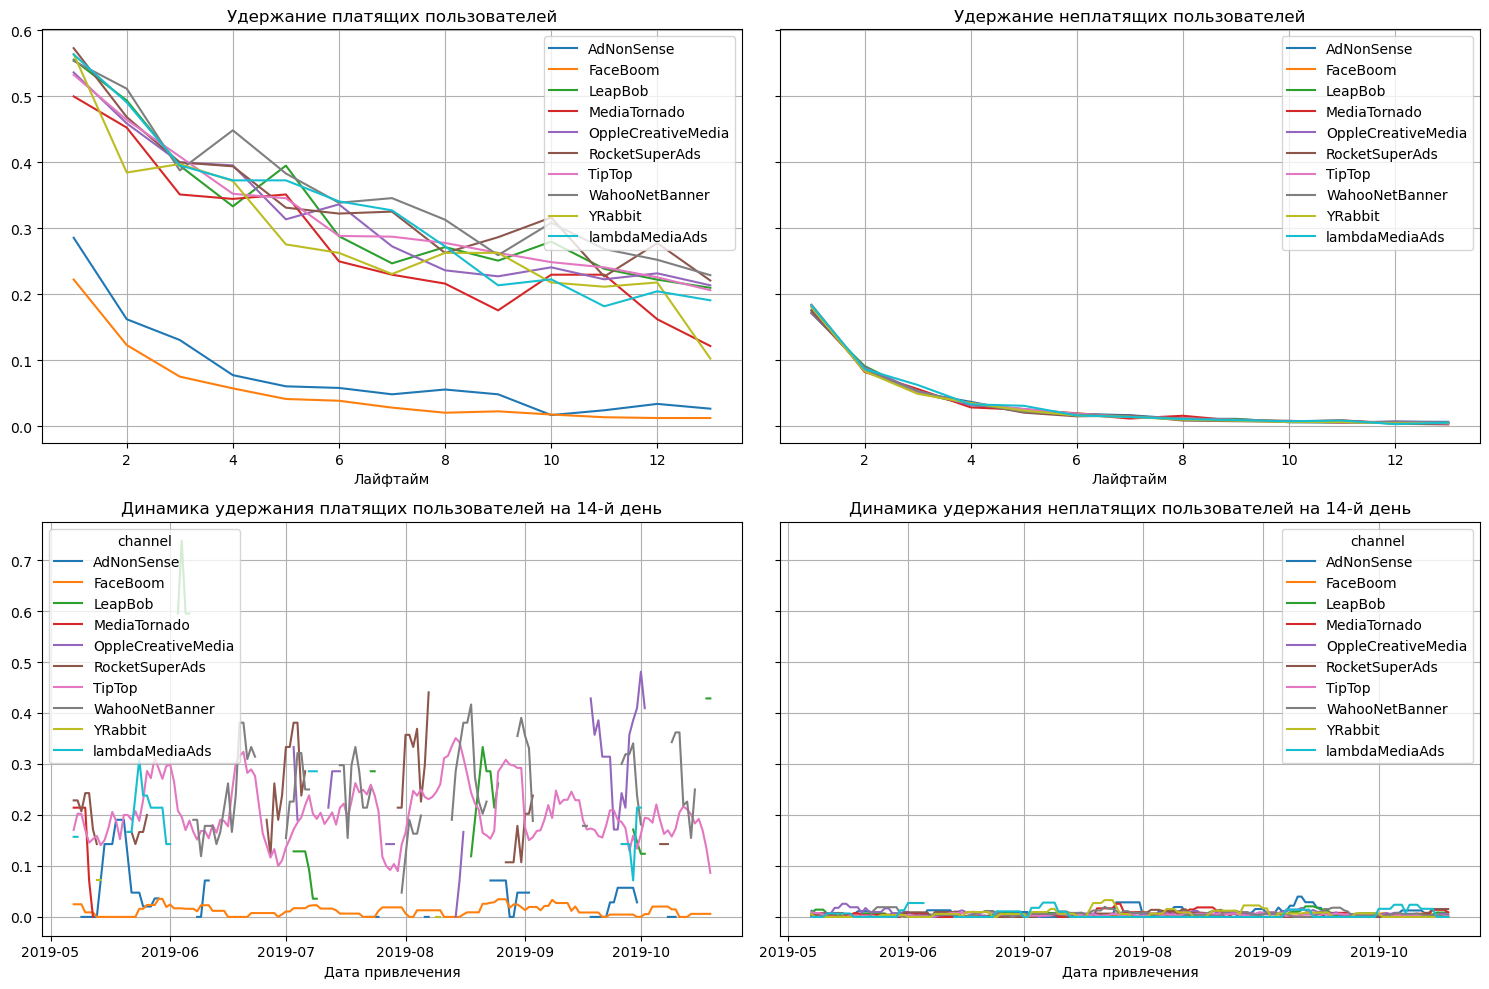

In [39]:
retention_raw, retention_grouped, retention_history = get_retention(profiles
                                                                    , visits
                                                                    , observation
                                                                    , horizon
                                                                    , dimensions=['channel'])
plot_retention(retention_grouped, retention_history, horizon) 

#### В разбивке по устройствам КОНВЕРСИЯ

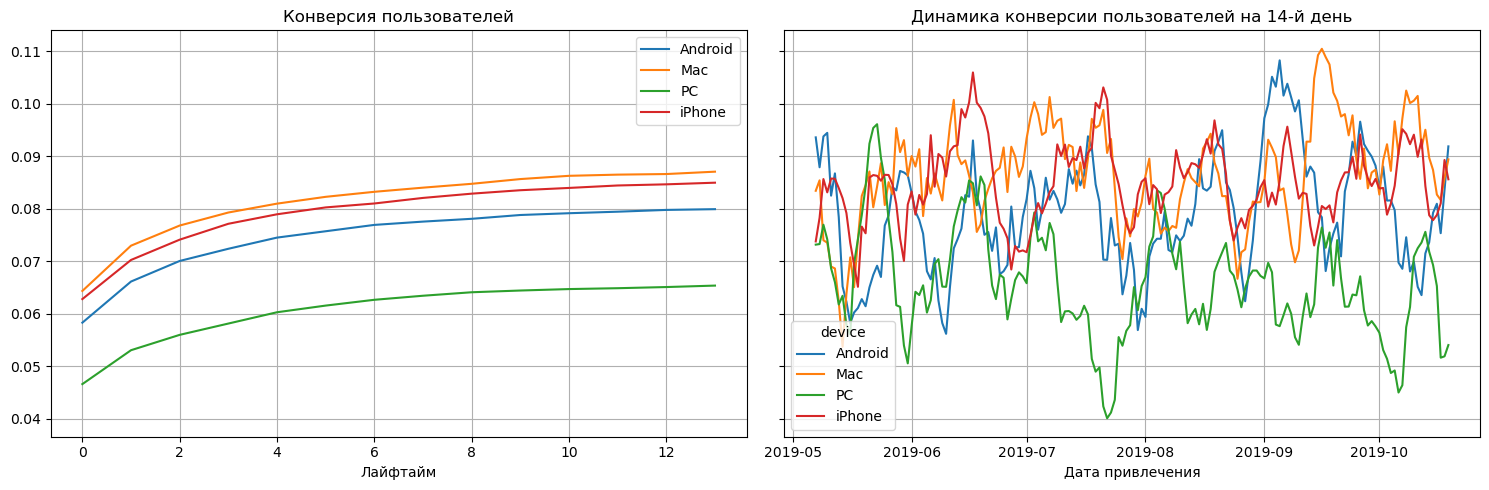

In [40]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles
                                                                        , orders
                                                                        , observation
                                                                        , horizon
                                                                        , dimensions=['device'])
plot_conversion(conversion_grouped, conversion_history, horizon) 

#### В разбивке по устройствам УДЕРЖАНИЕ

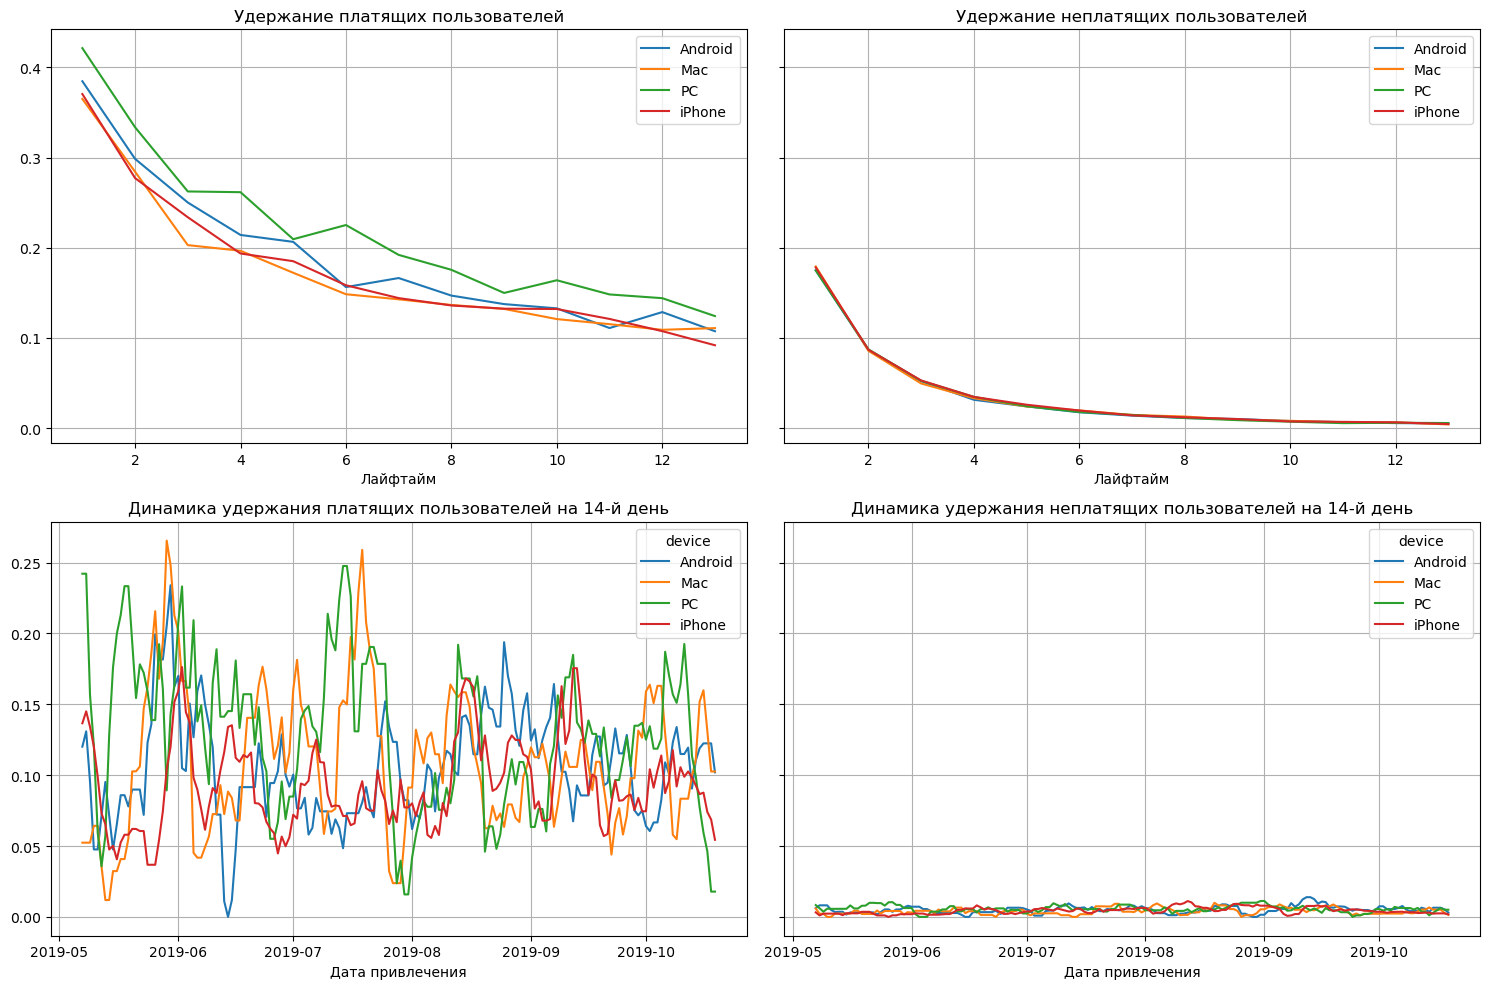

In [41]:
retention_raw, retention_grouped, retention_history = get_retention(profiles
                                                                    , visits
                                                                    , observation
                                                                    , horizon
                                                                    , dimensions=['device'])
plot_retention(retention_grouped, retention_history, horizon) 

#### В разбивке по странам КОНВЕРСИЯ

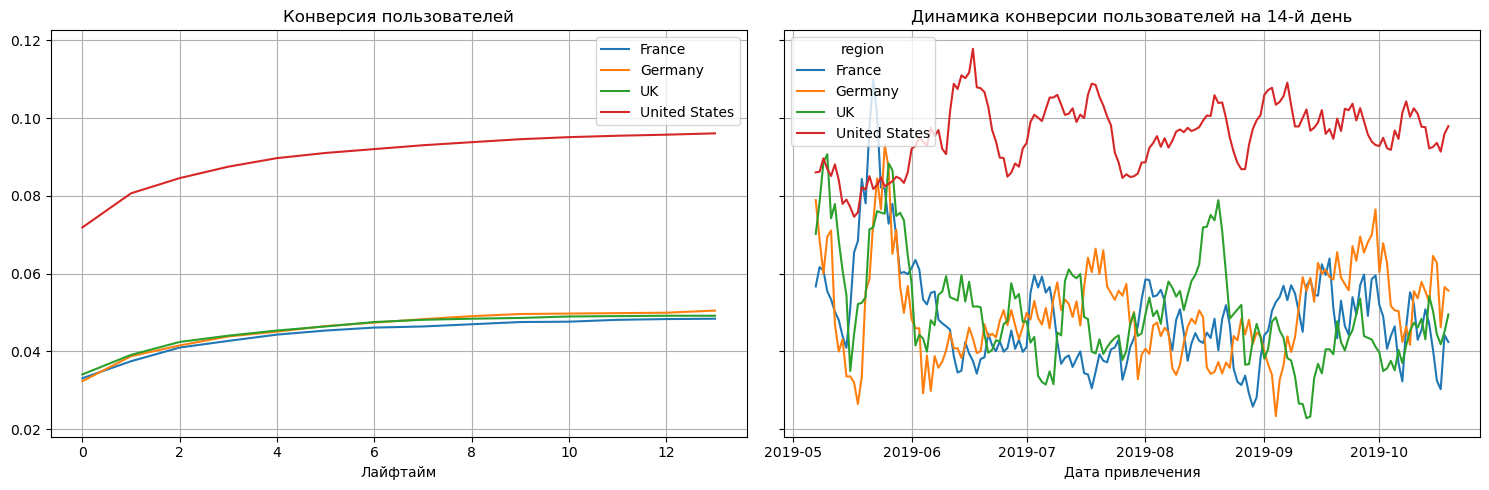

In [42]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles
                                                                        , orders
                                                                        , observation
                                                                        , horizon
                                                                        , dimensions=['region'])
plot_conversion(conversion_grouped, conversion_history, horizon) 

#### В разбивке по странам УДЕРЖАНИЕ

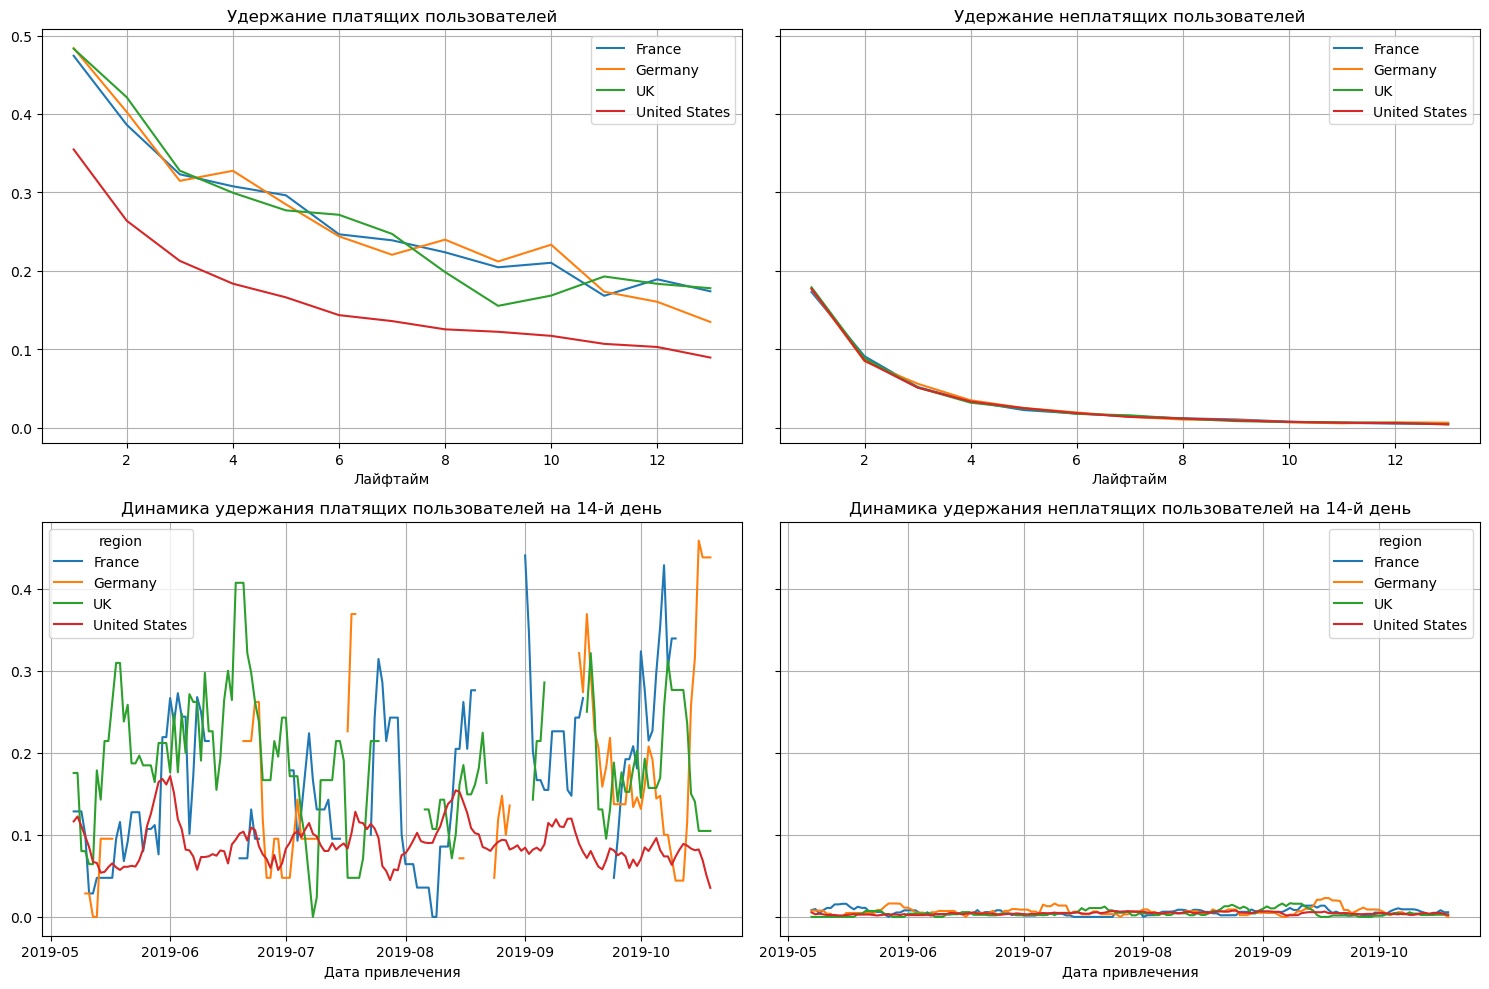

In [43]:
retention_raw, retention_grouped, retention_history = get_retention(profiles
                                                                    , visits
                                                                    , observation
                                                                    , horizon
                                                                    , dimensions=['region'])
plot_retention(retention_grouped, retention_history, horizon) 

**ВЫВОД:**

    1) Самую большую конверсию имеют пользователи из США.
    
    2) Пользователи ПК имеют самую маленькую конверсию
    
    3) Источники FaceBoom, AdNonSense, LambdaMediaAds, TipTop имеют лучшую конверсию
    
    4) Самая плохая конверсия у источников WahooNetBanner, LeapBop.

### Проанализируем окупаемость рекламы

#### В разбивке по устройствам

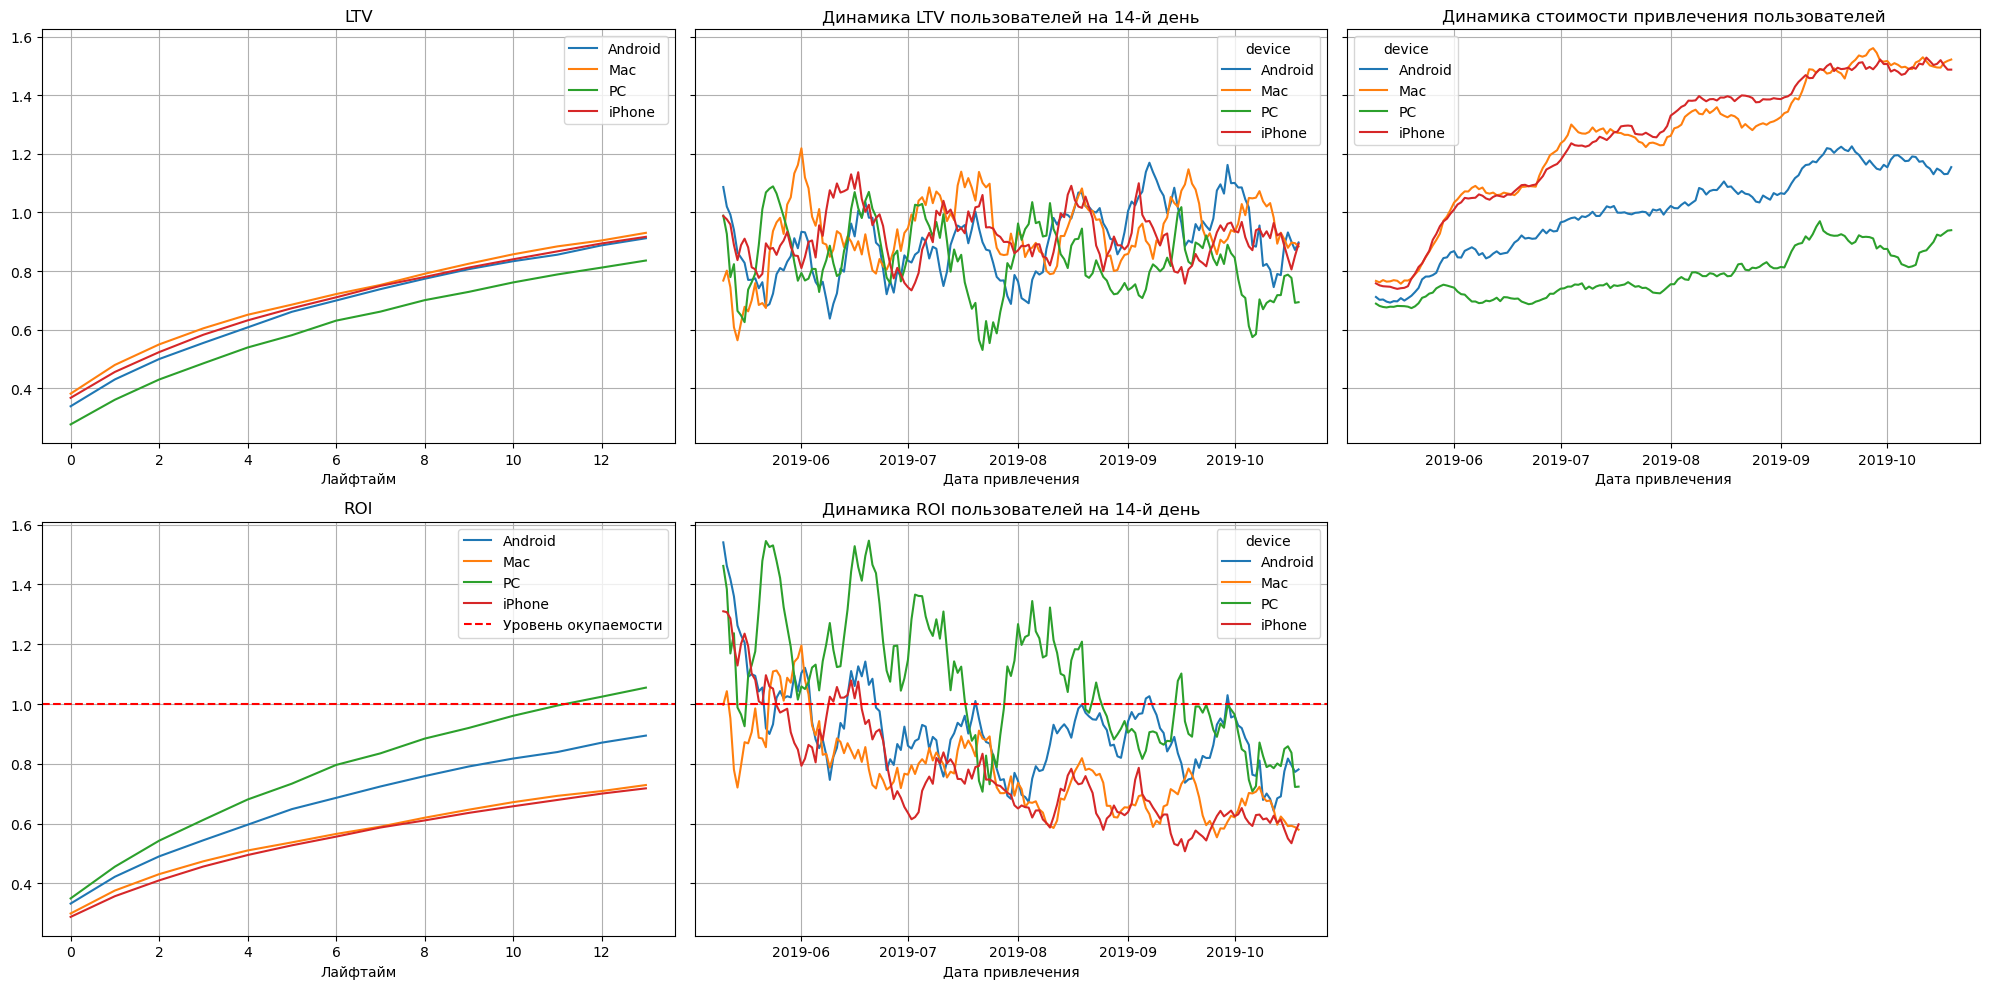

In [44]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles
                                                                      , orders
                                                                      , observation
                                                                      , horizon
                                                                      , dimensions=['device'])
plot_ltv_roi(ltv_grouped
             , ltv_history
             , roi_grouped
             , roi_history
             , horizon
             , window=10) 

#### В разбивке по странам

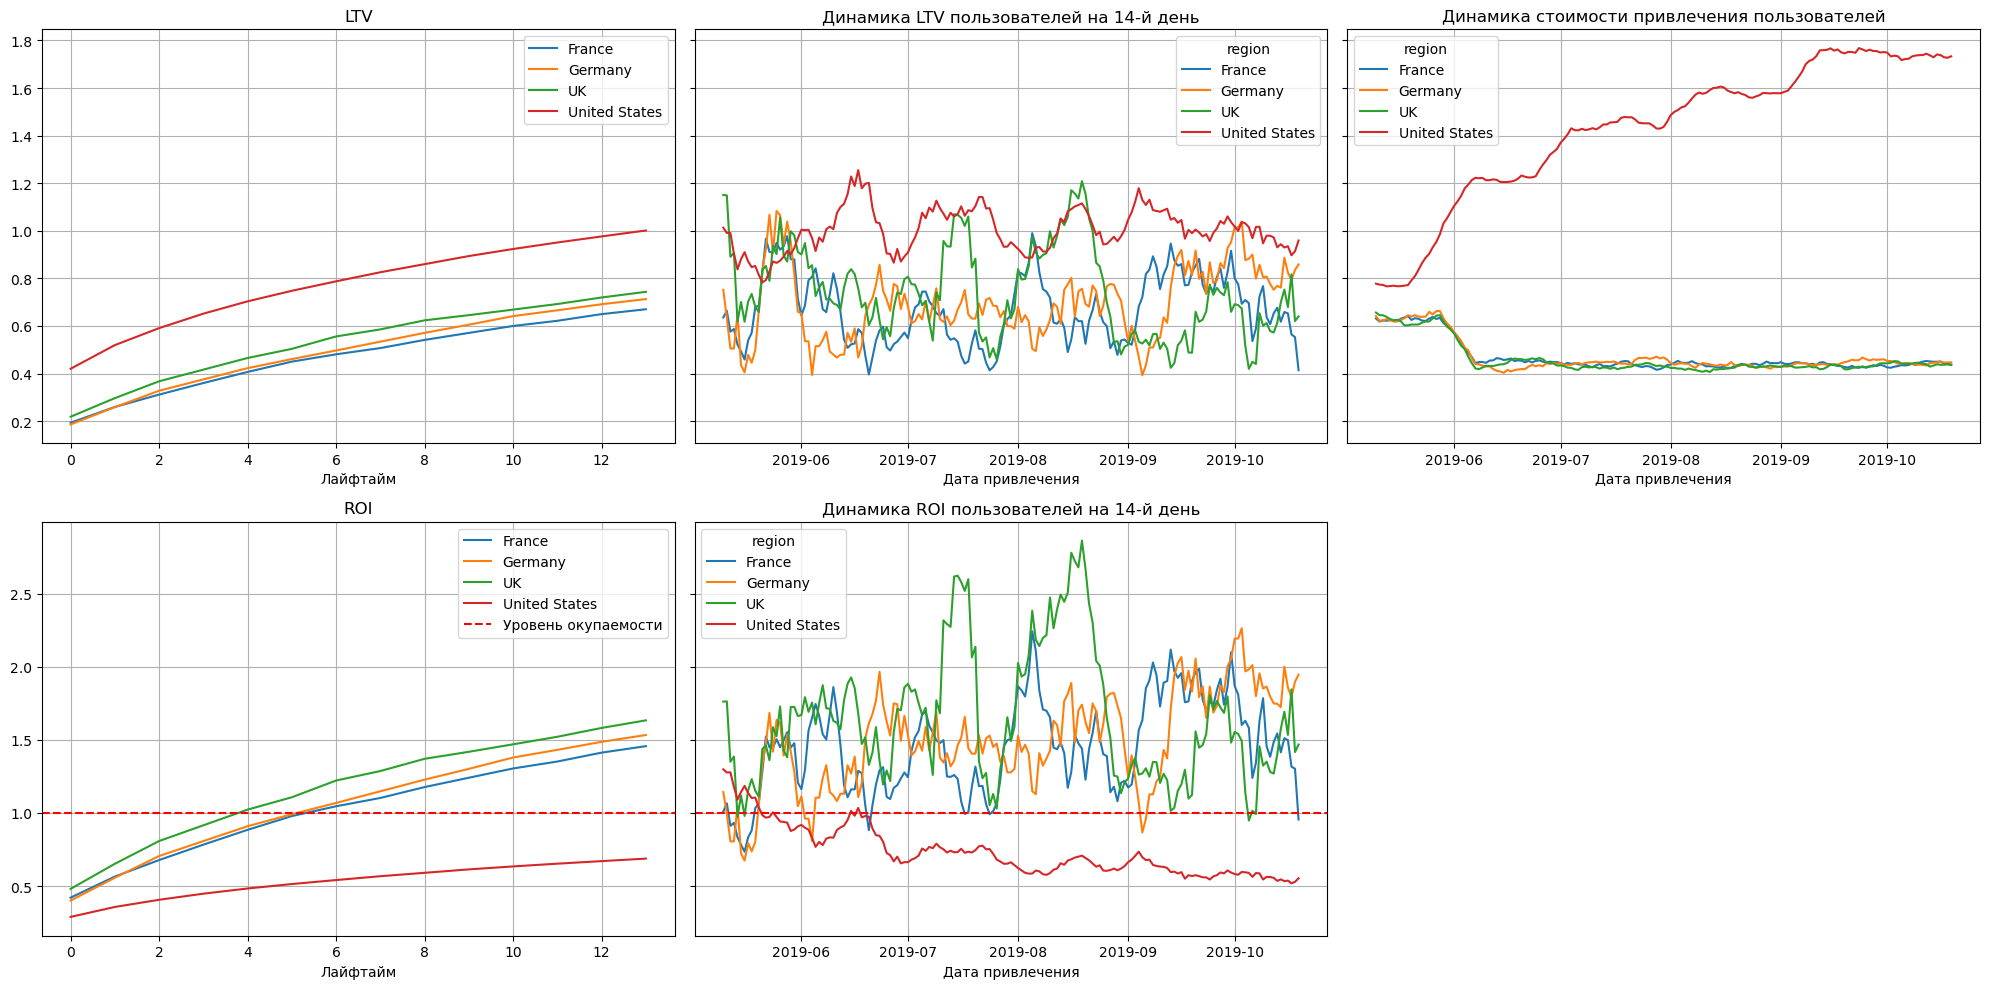

In [45]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles
                                                                      , orders
                                                                      , observation
                                                                      , horizon
                                                                      , dimensions=['region'])
plot_ltv_roi(ltv_grouped
             , ltv_history
             , roi_grouped
             , roi_history
             , horizon
             , window=10) 

#### В разбивке по рекламным каналам

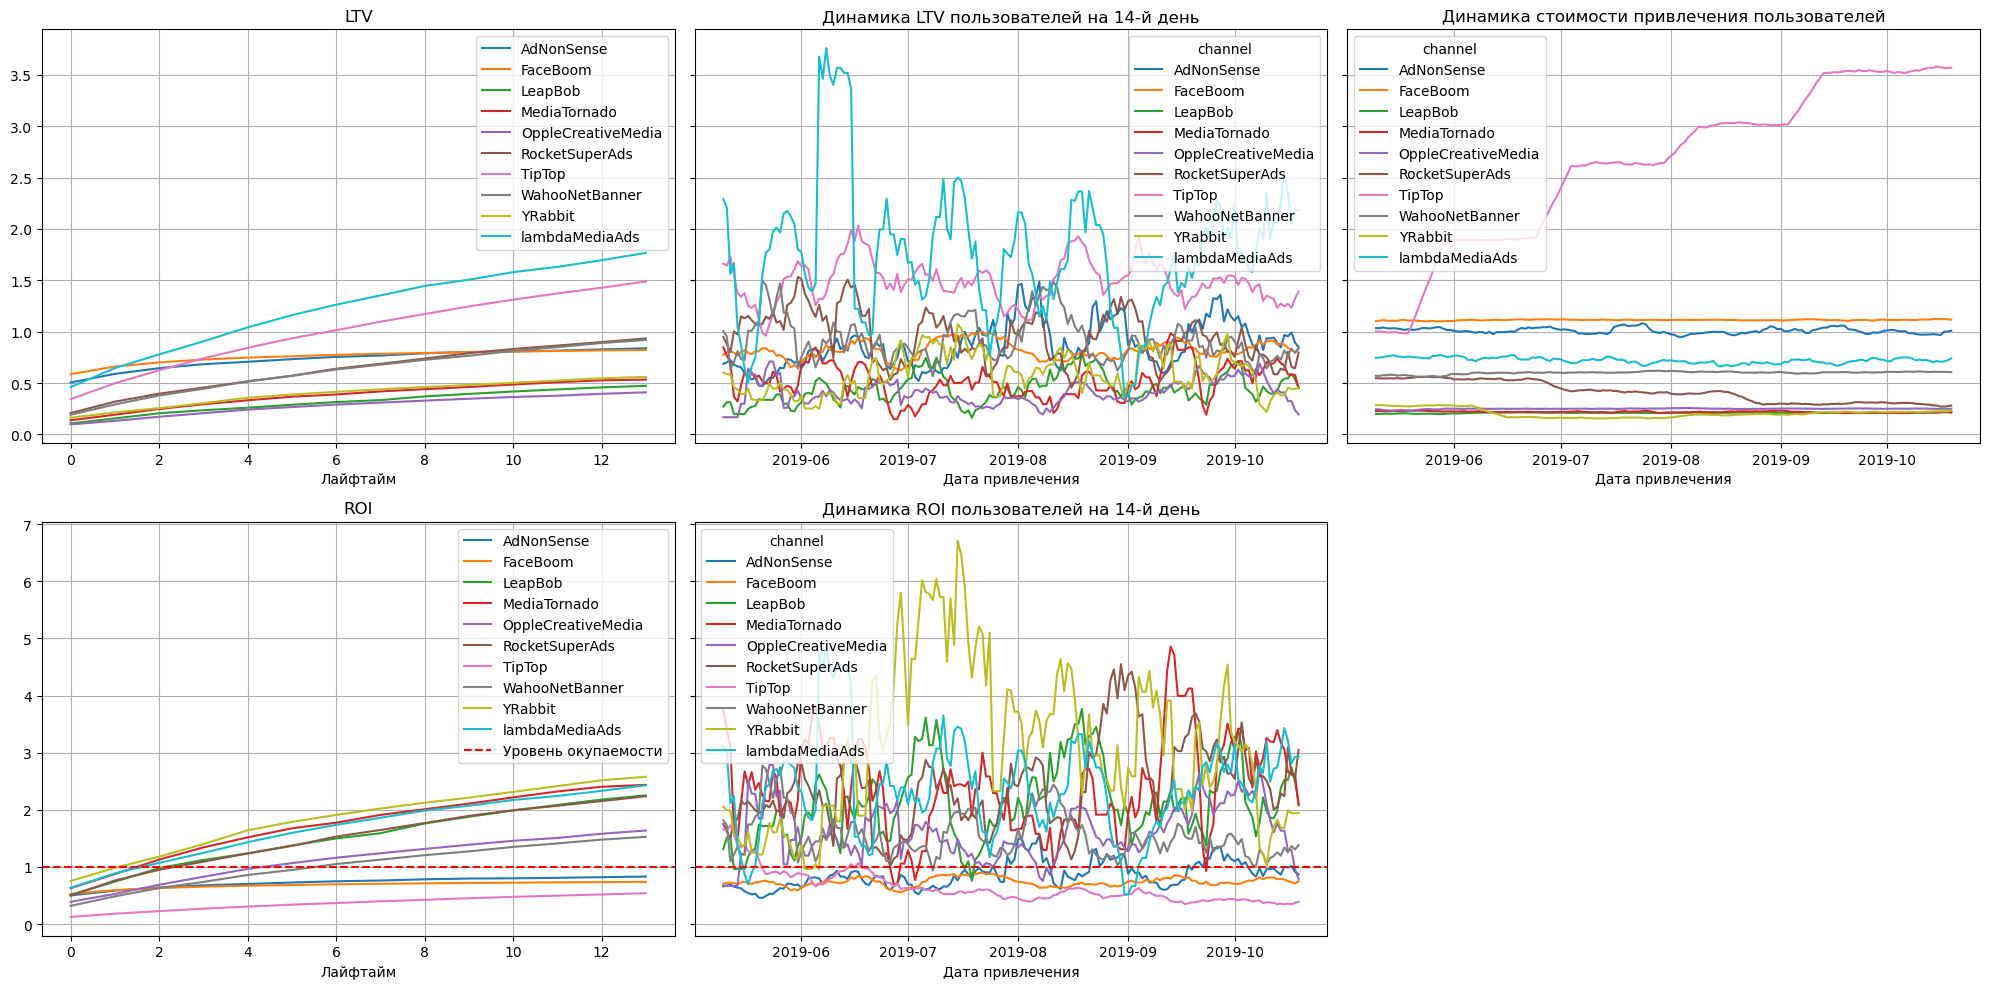

In [46]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles
                                                                      , orders
                                                                      , observation
                                                                      , horizon
                                                                      , dimensions=['channel'])
plot_ltv_roi(ltv_grouped
             , ltv_history
             , roi_grouped
             , roi_history
             , horizon
             , window=10) 

## ВЫВОДЫ<a id="1"></a>

**Окупается ли реклама, направленная на привлечение пользователей в целом?**

Реклама не окупается. В стране с самым большим кол-вом пользователей, через 2 недели ROI ниже 1. До июня 2019 года реклама окупалась.


**Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?**

Пользователи iphone или mac из США, привлечённые при помощи рекламы  FaceBoom, LeapBob и TipTop не окупаются за 2 недели

**Чем могут быть вызваны проблемы окупаемости?**

Постоянно растёт CAC, упор на пользователей из США, большие деньги вкладываются в неокупаемые рекламные компании.

**Рекомендации:**

Изменить стратегию привлечения новых пользователей, а именно: изменить подход к закупке рекламы вместо закупок у FaceBoom, TipTop, LeapBob попробовать увеличить финансирование MediaTornado, YRabbit и LambdaMediaAds. Вместо привлечения пользователей продукции apple (которые не окупаются) попробовать привлекать пользователей андроид и ПК. Повысить удержание для пользователей из США, например с помощью введения персонализированных UX-стратегий, e-mail рассылок, персональных рекомендаций, push-уведомлений. Можно ввести определённые "награды" или привилегии для постоянных пользователей. Для канала FaceBoom можно настроить более таргетированное привлечение, направленное на пользователей с необходимыми характеристиками. Также, можно ввести поощрение пользователей за репосты контента и прочий социальный engagement, связанный с приложением, в данном канале.